In [51]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
import sys
import swifter
# Vectorizer for dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])
# nlp.Defaults.stop_words.add("roll")
nlp.Defaults.stop_words |= {"roll","look","know", "going", "looking", "looks"}
sns.set_theme()

In [52]:
def wordcloud(text):
  wordcloud = WordCloud(background_color="white").generate(text)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")

In [53]:
# Abertura dos arquivos
podcast_file = open('data/general_podcasts.csv', mode='r')
skills_file = open('data/skills_dataset.csv', mode='r')
CR_file = open('data/CR_skills_dataset.csv', mode='r')

In [54]:
skill_list = ['acrobatics',
 'animal handling',
 'arcana',
 'athletics',
 'deception',
 'history',
 'insight',
 'intimidation',
 'investigation',
 'medicine',
 'nature',
 'perception',
 'performance',
 'persuasion',
 'religion',
 'sleight of hand',
 'stealth',
 'survival']

In [55]:
valid_columns = ["skill", "backward_text"]

In [56]:
podcast_file_df = pd.read_csv(podcast_file, usecols=valid_columns)

In [57]:
skills_file_df = pd.read_csv(skills_file, usecols=valid_columns)

In [58]:
CR_file_df = pd.read_csv(CR_file, usecols=valid_columns)

In [59]:
podcast_file_df = podcast_file_df.loc[podcast_file_df["skill"].str.lower().isin(skill_list)]

In [60]:
CR_file_df = CR_file_df.loc[CR_file_df["skill"].str.lower().isin(skill_list)]

In [61]:
skills_file_df = skills_file_df.loc[skills_file_df["skill"].str.lower().isin(skill_list)]

In [62]:
concatenated_df = pd.concat([podcast_file_df, skills_file_df, CR_file_df], ignore_index=True)

In [63]:
len(concatenated_df)

14616

In [64]:
concatenated_df['skill'] = concatenated_df['skill'].apply(lambda x: x.lower())
concatenated_df

,skill,backward_text
0,perception,going weekly for the rest of the experimental ...
1,performance,"by, like, logic, you know what I mean? So I ca..."
2,investigation,"success, you open yourself up to repercussions..."
3,insight,"success, you open yourself up to repercussions..."
4,perception,play in the NFL!” and he was like “No.” There’...
...,...,...
14611,investigation,(laughter) (sings) Continuity. Roll for contin...
14612,insight,"wall. There is a very, very faint scratch into..."
14613,deception,advice from when it comes to administrating my...
14614,stealth,I was under the assumption that you had to be ...


In [65]:
def filter_functions(text):
    splited_text = [i.strip('-?!:') for i in text.split(' ')]
    joined_text = ' '.join(splited_text)
    return joined_text

In [66]:
def filter_irrelevant_words(phrase):
    filtered_phrase = filter_functions(phrase)
    doc = nlp(filtered_phrase)
    word_list = []
    for token in doc:
        if not token.is_stop and token.pos_ in ("VERB", "NOUN") and len(token.shape_) > 2:
            filtered_text = token.text
            word_list.append(token.text)
    
    return word_list

In [67]:
%time doc = nlp(concatenated_df["backward_text"][4].lower())
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)
print(concatenated_df["backward_text"][4])
print(filter_irrelevant_words(concatenated_df["backward_text"][4]))



CPU times: user 9.6 ms, sys: 0 ns, total: 9.6 ms
Wall time: 8.84 ms
play play VERB  xxxx True False
in in ADP  xx True True
the the DET  xxx True True
nfl nfl NOUN  xxx True False
! ! PUNCT  ! False False
” " PUNCT  ” False False
and and CCONJ  xxx True True
he he PRON  xx True True
was be VERB  xxx True True
like like ADP  xxxx True False
“ " PUNCT  “ False False
no no INTJ  xx True True
. . PUNCT  . False False
” " PUNCT  ” False False
there there PRON  xxxx True True
’s ’ VERB  ’x False True
some some DET  xxxx True True
really- really- NOUN  xxxx- False False
we we PRON  xx True True
have have VERB  xxxx True True
n’t n’t PART  x’x False True
— — PUNCT  — False False
i I PRON  x True True
really really ADV  xxxx True True
like like VERB  xxxx True False
this this DET  xxxx True True
idea idea NOUN  xxxx True False
of of ADP  xx True True
a a DET  x True True
chosen choose VERB  xxxx True False
that that DET  xxxx True True
’s ’ VERB  ’x False True
just just ADV  xxxx True True
like

In [68]:
# concatenated_df['backward_text'] = [re.sub('[^A-Za-z0-9]+', ' ', i).lower() for i in concatenated_df["backward_text"]]
concatenated_df['backward_text'] = [i.lower() for i in concatenated_df["backward_text"]]
concatenated_df

,skill,backward_text
0,perception,going weekly for the rest of the experimental ...
1,performance,"by, like, logic, you know what i mean? so i ca..."
2,investigation,"success, you open yourself up to repercussions..."
3,insight,"success, you open yourself up to repercussions..."
4,perception,play in the nfl!” and he was like “no.” there’...
...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...
14612,insight,"wall. there is a very, very faint scratch into..."
14613,deception,advice from when it comes to administrating my...
14614,stealth,i was under the assumption that you had to be ...


In [69]:
%time concatenated_df["filtered_words"] = concatenated_df["backward_text"].swifter.apply(filter_irrelevant_words)

Pandas Apply:   0%|          | 0/14616 [00:00<?, ?it/s]

CPU times: user 1min 23s, sys: 180 ms, total: 1min 23s
Wall time: 1min 23s


In [70]:
concatenated_df

,skill,backward_text,filtered_words
0,perception,going weekly for the rest of the experimental ...,"[rest, arcs, starting, week, guess, episode, h..."
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, mean, wanna, help, inhaling, teeth, ss..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
4,perception,play in the nfl!” and he was like “no.” there’...,"[play, nfl, like, idea, chosen, crosstalk, thank]"
...,...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."
14614,stealth,i was under the assumption that you had to be ...,"[assumption, rolo, level, bath, house, house, ..."


In [71]:
def nlp_vs_ordinary(df):
    backward_text_df = df.groupby('skill')['backward_text'].apply(lambda x: [str(x).split(' ') for i in x])
    backward_text_df = backward_text_df.apply(lambda x: [item for sublist in x for item in sublist if item])
#     backward_text_df = [x for x in backward_text_df if x]
    filtered_words_df = df.groupby('skill')['filtered_words'].apply(lambda x: [item for sublist in x for item in sublist])
#     backward_text = df['backward_text'].to_numpy().flatten()
#     filtered_words = df['filtered_words'].to_numpy().flatten()
#     fig, axs = plt.subplots(ncols=2)
#     plot = sns.barplot(x="quantidade",y=filtered_words_df['skill']['filtered_words'], data=filtered_words_df)
    for i in skill_list:
        bar_graphic_vs(backward_text_df[i], filtered_words_df[i], title=i)
#     bar_graphic(lista=filtered_words_df['acrobatics'], pos=1)
#         backward_text_dict = ocorrencias(backward_text_df[i])
#         filtered_words_dict = ocorrencias(filtered_words_df[i])
#         sns.barplot(x=backward_text_df[i], data=backward_text_df[i])
#         sns.barplot(x='value', y='wage', data=df_melt, ax=axs[0])
#         sns.barplot(x='value', y='wage', data=df_melt, ax=axs[1])
#         sns.barplot()

#     print(filtered_words_df.index)


#     ## Wordcloud
#     for i in skill_list:
#         wordcloud(' '.join(backward_text_groupby[i]))
#         wordcloud(' '.join(filtered_words_groupby[i]))
 
#     print(backward_text_df)

In [72]:
"""
    Função que transforma uma lista de palavras bem formatadas em um dicionário de ocorrências.
    Ex.:
        > x = ['Philipe', 'Jc', 'Victor', 'Philipe', 'Jc', 'Victor', 'Victor', 'Jc']
        > ocorrencias(x)
        > {'Philipe': 2, 'Jc': 3, 'Victor': 3}
"""
def ocorrencias(lista):
    dict_ocorrencias = {}
    for i in lista:
        if i in dict_ocorrencias:
            dict_ocorrencias[i] += 1
        else:
            dict_ocorrencias[i] = 1
    return dict_ocorrencias

In [73]:
"""
    Função que dado um dicionário de ocorrências ou lista bem formatada,
    plota um gráfico com as palavras com maior ocorrência (15 por padrão).
"""
def bar_graphic(dicionario=None, paleta="rocket", lista = None, max=15, dim=(12,9), title=None, pos=0):
    # Se não tiver dicionario, vai ter uma lista
    if dicionario is None:
        if lista is not None:
            # A lista é então convertida para dicionario através da função de ocorrencias
            dicionario = ocorrencias(lista)
    
    # O dicionario é transformado em dataframe para melhor manipulação
    df = pd.DataFrame(dicionario.items(), columns=["key", "value"])
    # Dataframe ordenado de forma decrescente e com o máximo estipulado
    df = df.sort_values(by="value", ascending=False).head(max)
    
    # É então re-convertido em dicionario
    top_dicionario = dict(df.values)
    
    # As chaves e valores são convertidas em lista para auxiliar na plotagem do gráfico
    palavras = list(top_dicionario.keys())
    valores = list(top_dicionario.values())

    ## Plot
    # Define dimensões para o gráfico
    fig_dims = dim
    fig, axs = plt.subplots(figsize=fig_dims, ncols=2)
    # Configura o eixo, paleta e dimensões do gráfico
    plot = sns.barplot(x=palavras,y=valores, palette=paleta, ax=axs[pos])
    # Define o título do gráfico
    if title is None:
        plt.title(f'Top {max} Ocorrências')
    else:
        plt.title(title)
    # Rotaciona a legenda de cada barra e plota o gráfico
    plt.setp(plot.get_xticklabels(), rotation=45)

In [74]:
"""
    Função que dado um dicionário de ocorrências ou lista bem formatada,
    plota um gráfico com as palavras com maior ocorrência (15 por padrão).
"""
def bar_graphic_vs(lista1, lista2, max=15, dim=(14,7), title=None, pos=0, palette="mako"):
    dicionario1 = ocorrencias(lista1)
    dicionario2 = ocorrencias(lista2)
    # O dicionario é transformado em dataframe para melhor manipulação
    df1 = pd.DataFrame(dicionario1.items(), columns=["key", "value"])
    df2 = pd.DataFrame(dicionario2.items(), columns=["key", "value"])
    # Dataframe ordenado de forma decrescente e com o máximo estipulado
    df1 = df1.sort_values(by="value", ascending=False).head(max)
    df2 = df2.sort_values(by="value", ascending=False).head(max)
    # É então re-convertido em dicionario
    top_dicionario1 = dict(df1.values)
    top_dicionario2 = dict(df2.values)
    # As chaves e valores são convertidas em lista para auxiliar na plotagem do gráfico
    palavras1 = list(top_dicionario1.keys())
    palavras2 = list(top_dicionario2.keys())
    
    valores1 = list(top_dicionario1.values())
    valores2 = list(top_dicionario2.values())

    ## Plot
    # Define dimensões para o gráfico
    fig_dims = dim
    fig, axs = plt.subplots(figsize=fig_dims, ncols=2)
    # Configura o eixo, paleta e dimensões do gráfico
    plot = sns.barplot(x=palavras1,y=valores1, ax=axs[0])
    plot2 = sns.barplot(x=palavras2,y=valores2, ax=axs[1], palette=palette)
    # Define o título do gráfico
    plt.suptitle(title, y=0.95, fontsize=20)
    # Rotaciona a legenda de cada barra e plota o gráfico
    plt.setp(plot.get_xticklabels(), rotation=45)
    plt.setp(plot2.get_xticklabels(), rotation=45)
    

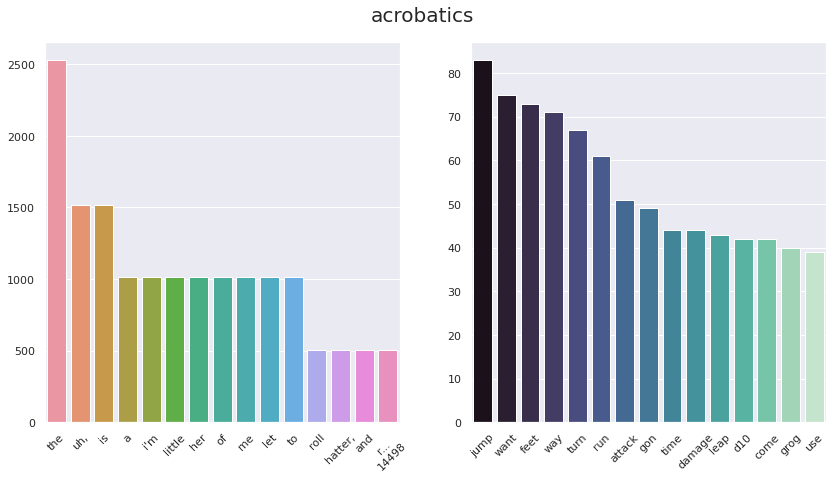

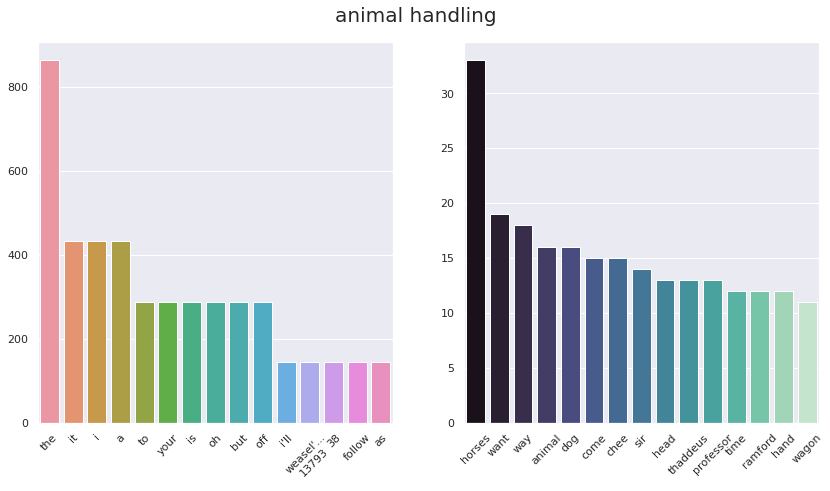

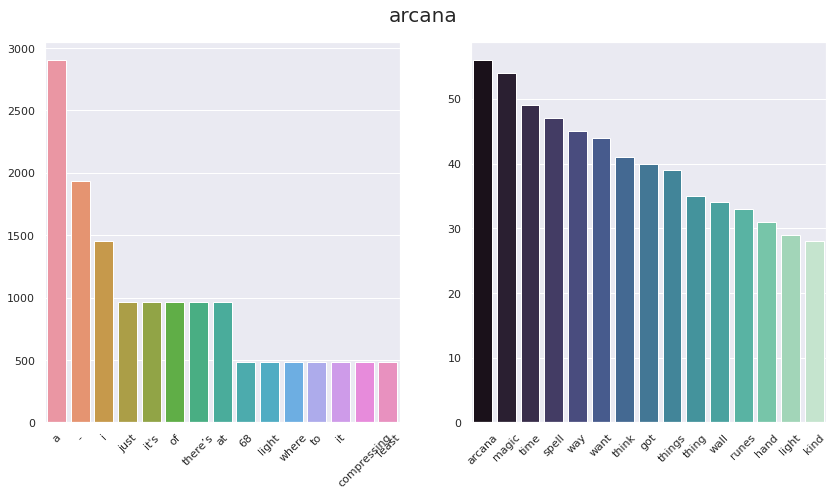

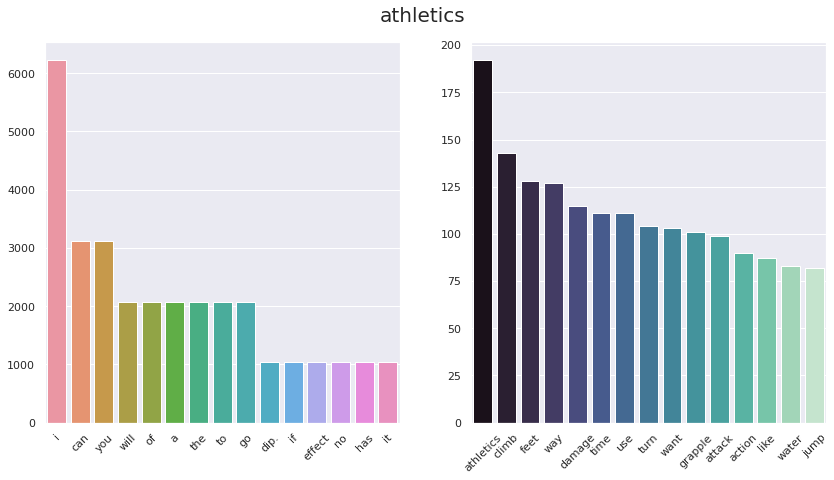

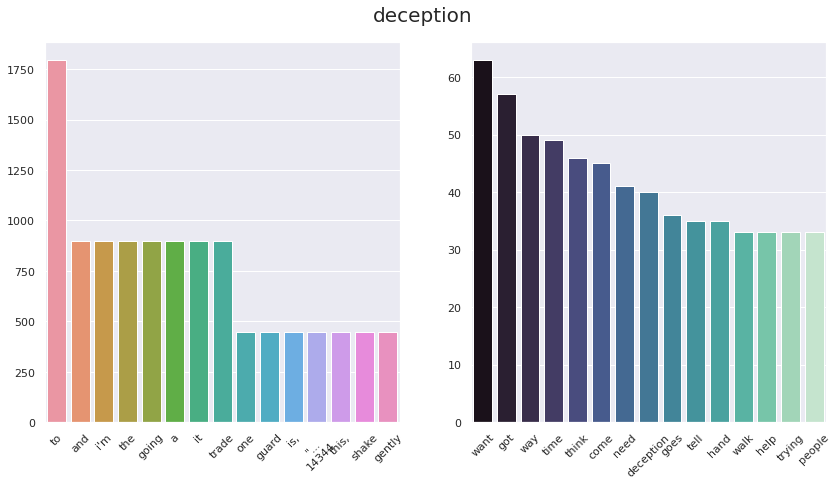

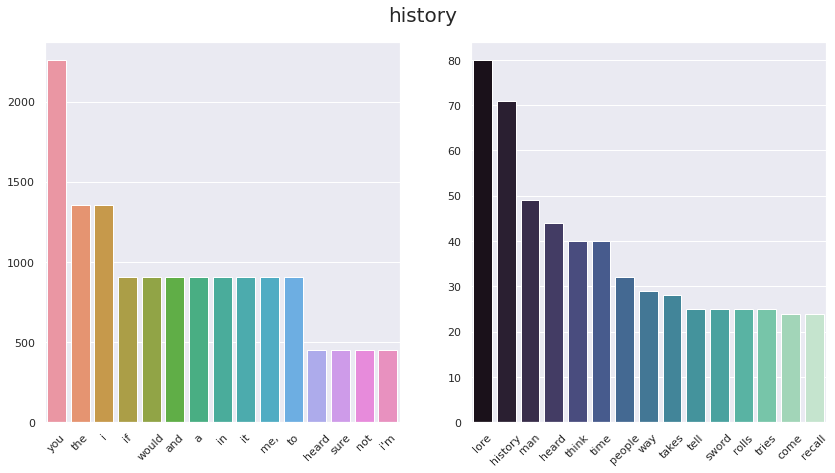

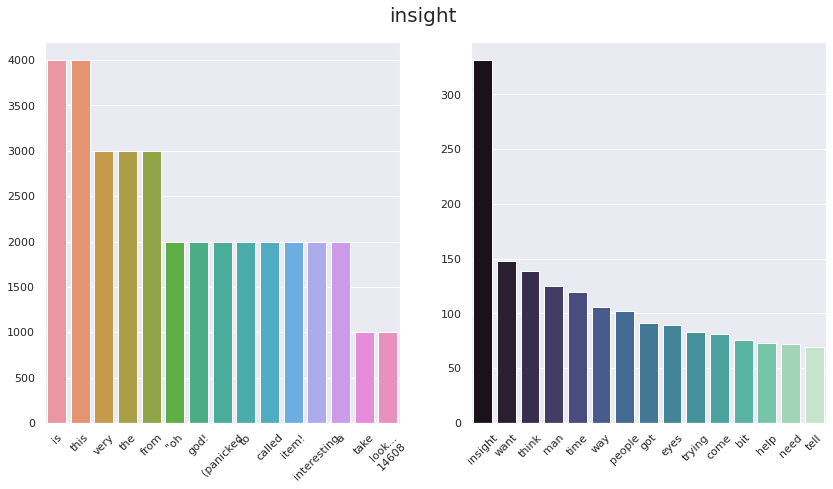

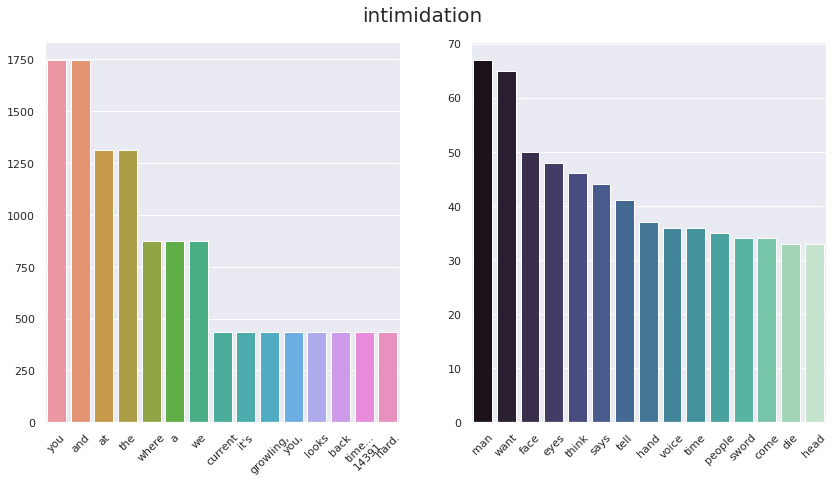

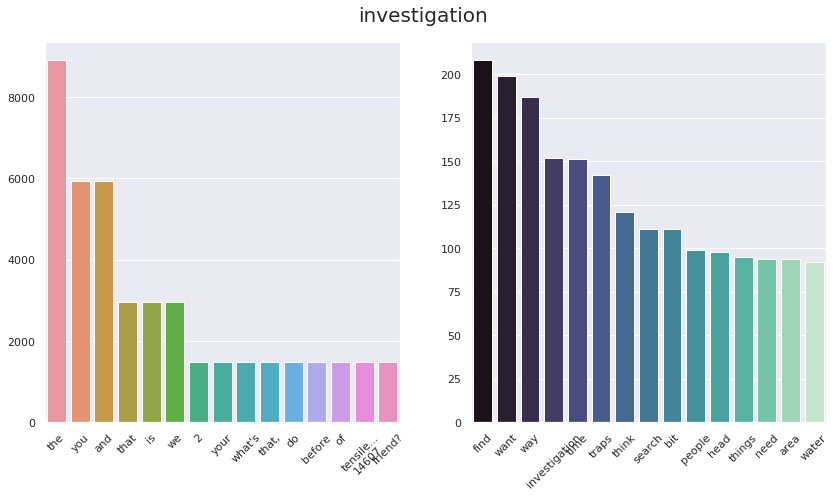

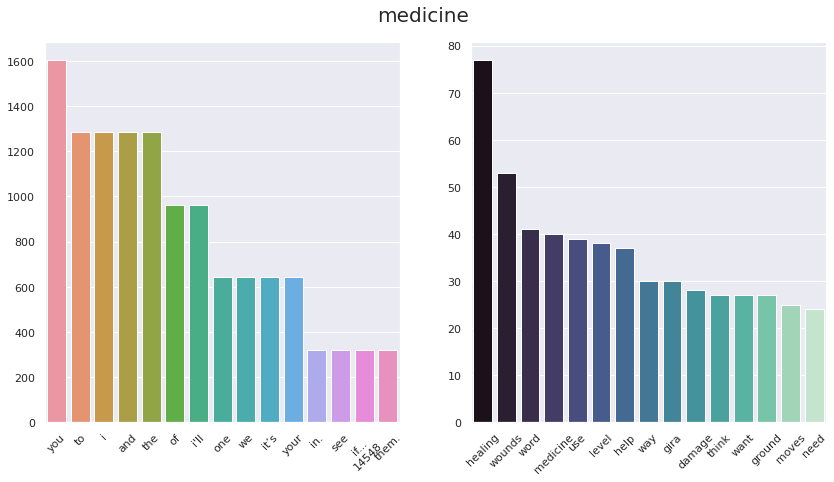

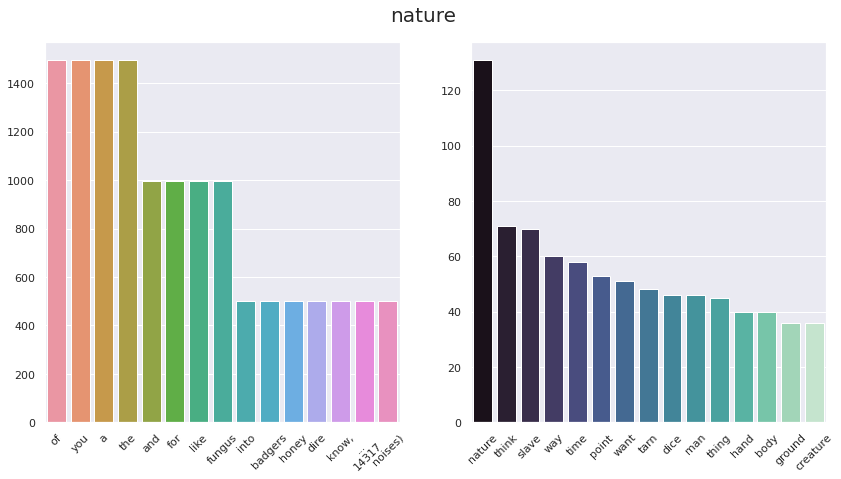

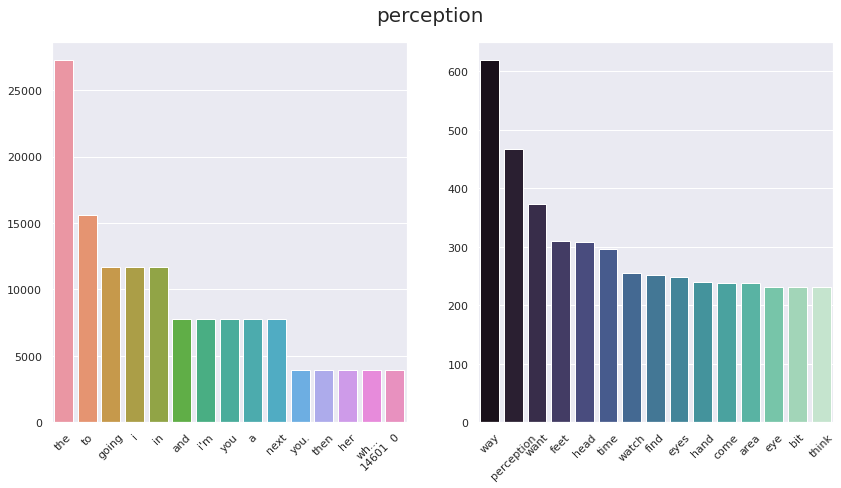

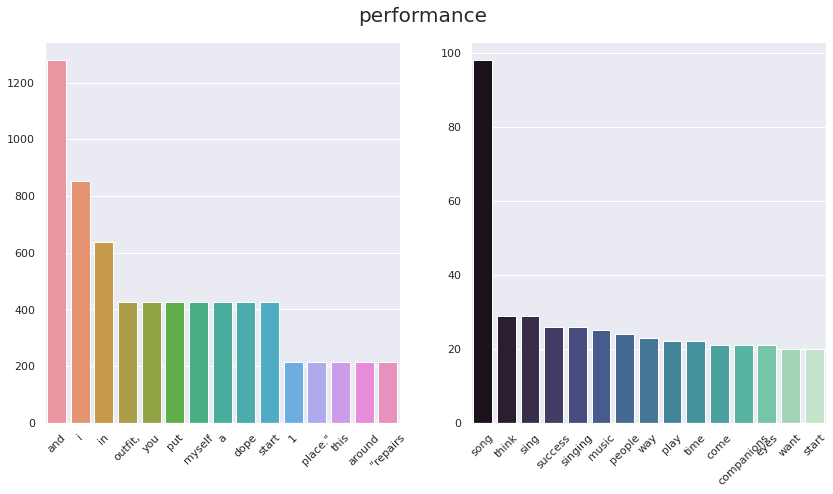

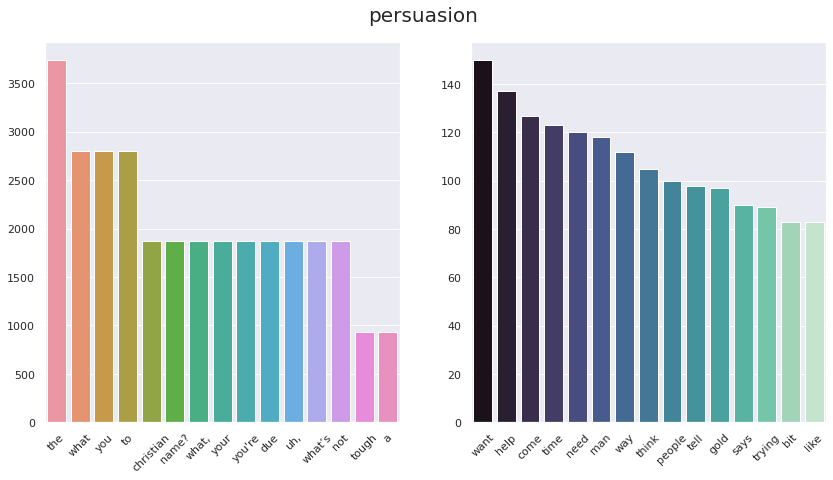

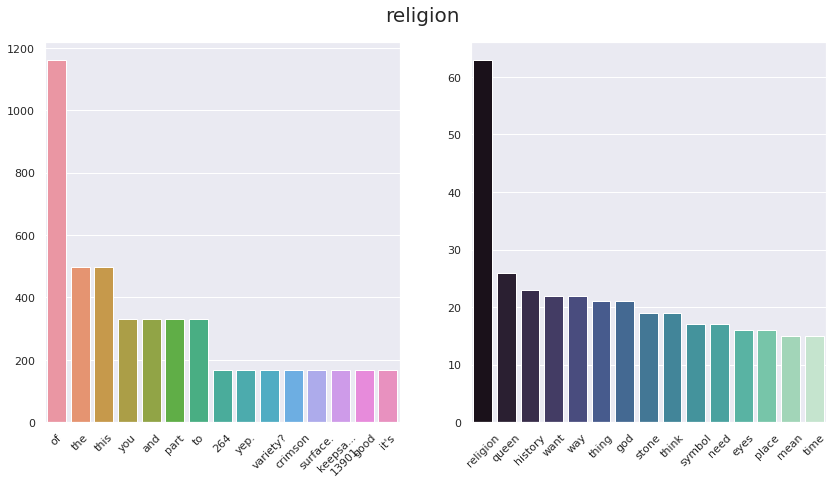

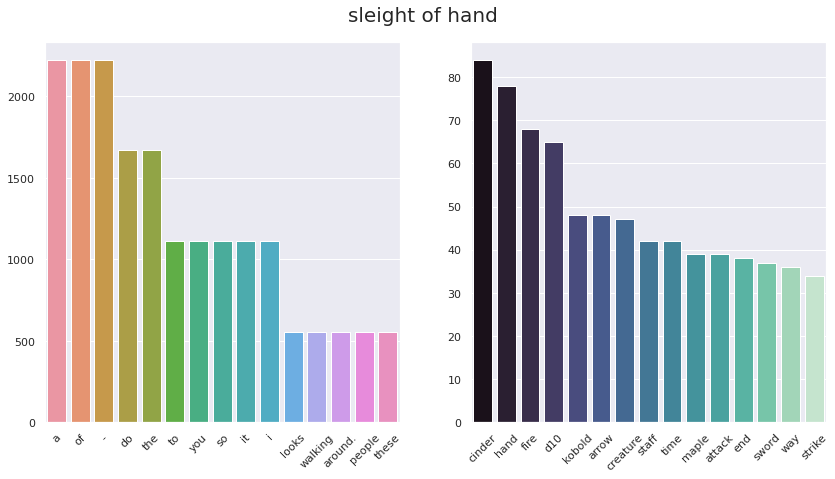

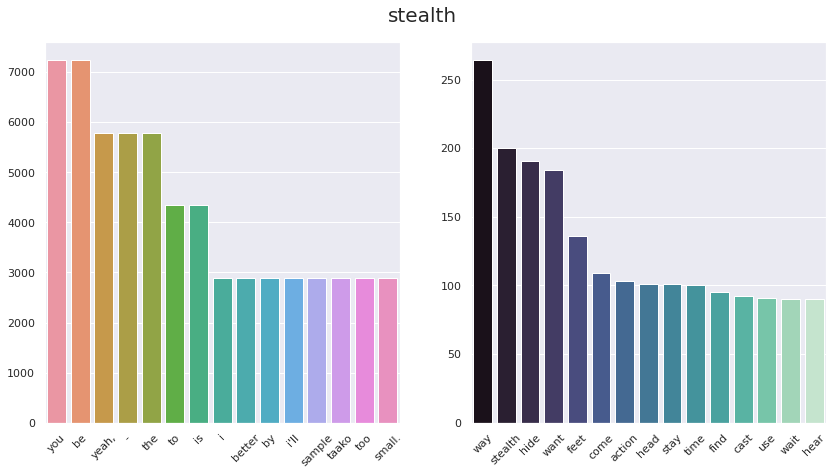

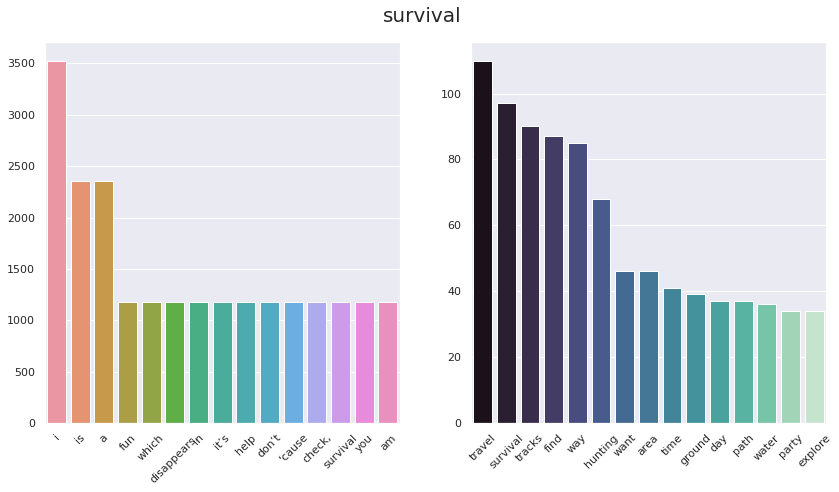

In [75]:
nlp_vs_ordinary(concatenated_df)

In [76]:
concatenated_df

,skill,backward_text,filtered_words
0,perception,going weekly for the rest of the experimental ...,"[rest, arcs, starting, week, guess, episode, h..."
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, mean, wanna, help, inhaling, teeth, ss..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
4,perception,play in the nfl!” and he was like “no.” there’...,"[play, nfl, like, idea, chosen, crosstalk, thank]"
...,...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."
14614,stealth,i was under the assumption that you had to be ...,"[assumption, rolo, level, bath, house, house, ..."


In [77]:
word_list = concatenated_df['filtered_words'].apply(lambda x: ' '.join(x)).tolist()
word_list

['rest arcs starting week guess episode hope screw',
 'logic mean wanna help inhaling teeth ssssssssssssss logic pulling sun',
 'success open repercussions reper help exposing danger',
 'success open repercussions reper help exposing danger',
 'play nfl like idea chosen crosstalk thank',
 'dealing consequences spellcasting rolled',
 'booze palmer mean arnold palmer loves party laugh chuckles booze arnold',
 'mark experience want failed crosstalk think way crosstalk',
 'leaning shooting snake length body heading water slides',
 'think information need gon investigate mystery rolls shit job dad',
 'trying wait thing think hiding choice choice hide pressure laughing hide bed',
 'love mark luck spent luck wanna line line aubrey fuego bastard',
 'services offer forestry service swimmer clothes duck',
 'rites omec companions expect receive healing care temple shrine established presence omec faith',
 'rage wants minute song thinking lines slaying protecting guidance got adventuring',
 'offer

In [78]:
# BOW and TFIDF, term must appear at least a number of times, limit max features and use ngrams
tfidf_vec = TfidfVectorizer(analyzer = 'word', max_df = 0.90, min_df = 3, ngram_range=(1, 2))
        
# Build dictionary to be able to use after training
tfidf_vec = tfidf_vec.fit(word_list)
        
# Get counts on terms
bow_tfidf = tfidf_vec.transform(word_list)

In [79]:
bow_tfidf.shape

(14616, 22765)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(bow_tfidf, concatenated_df['skill'], test_size=0.3, random_state = 42)

In [81]:
X_train.shape

(10231, 22765)

In [82]:
X_test.shape

(4385, 22765)

In [83]:
y_train.shape

(10231,)

In [84]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [85]:
y_pred = clf.predict(X_test)

In [86]:
confusion_matrix(y_test, y_pred)

array([[ 27,   0,   1,  22,   0,   0,   2,   0,   2,   2,   2,  68,   1,
          0,   0,   5,   6,   0],
       [  1,   2,   0,   2,   0,   0,   1,   0,   0,   0,   0,  36,   0,
          1,   0,   1,   3,   1],
       [  1,   0,  26,   8,   1,   2,   3,   2,  15,   1,   3,  79,   0,
          2,   3,   2,   1,   0],
       [ 11,   0,   1, 138,   0,   1,   2,   3,   3,   2,   4,  96,   0,
          4,   0,  10,  11,   1],
       [  1,   0,   0,   5,  18,   1,   7,   0,   3,   0,   0,  72,   3,
          2,   0,   2,   7,   2],
       [  0,   0,   5,  11,   0,  45,   2,   6,   7,   2,   1,  45,   2,
          4,   1,   3,   4,   2],
       [  0,   0,   0,   5,   6,   4, 101,   1,  11,   0,   3, 130,   0,
          8,   0,   1,   2,   2],
       [  0,   0,   0,  10,   0,   3,   3,  29,   4,   0,   2,  73,   1,
         13,   0,   4,   0,   1],
       [  2,   0,   2,  18,   0,   5,   9,   0, 101,   8,   1, 285,   0,
          4,   2,   2,  12,   5],
       [  0,   0,   0,   7,   0,   0,

In [87]:
# Plota a matriz de confusão
def plot_confusion_matrix(lst_skills, title, reals, predictions):
        ax = plt.axes()
        sns.heatmap(confusion_matrix(reals, predictions), xticklabels=lst_skills, yticklabels=lst_skills, ax=ax)
        ax.set_title(title)
        ax.set_ylabel('Real')
        ax.set_xlabel('Predicted')

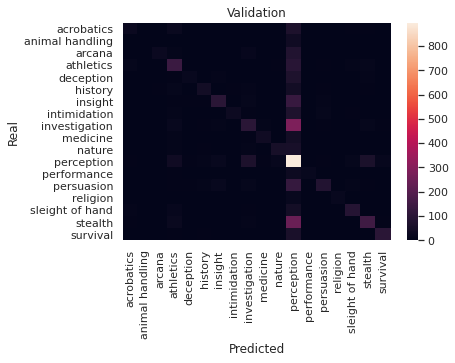

In [88]:
plot_confusion_matrix(skill_list, 'Validation', y_test, y_pred)

In [89]:
concatenated_df['skill'].value_counts()

perception         3898
investigation      1485
stealth            1447
athletics          1037
insight             999
persuasion          935
survival            588
sleight of hand     556
acrobatics          506
nature              499
arcana              484
history             452
deception           449
intimidation        437
medicine            321
performance         213
religion            166
animal handling     144
Name: skill, dtype: int64

In [90]:
# sample_df = concatenated_df.loc[concatenated_df["skill"] != "perception"]
sample_df = concatenated_df
sample_df

,skill,backward_text,filtered_words
0,perception,going weekly for the rest of the experimental ...,"[rest, arcs, starting, week, guess, episode, h..."
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, mean, wanna, help, inhaling, teeth, ss..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
4,perception,play in the nfl!” and he was like “no.” there’...,"[play, nfl, like, idea, chosen, crosstalk, thank]"
...,...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."
14614,stealth,i was under the assumption that you had to be ...,"[assumption, rolo, level, bath, house, house, ..."


In [91]:
# Rebalanceia as labels 
def data_leveler(df, lst_skills, min_obs):
    df_sample = pd.DataFrame() 
    for skill in lst_skills:
        # Get number of observations for skill
        num_obs = sum(df['skill'].values == skill)
        
        # Make a more homogeneous dataset for training
        if num_obs > min_obs:
            # If skill has more than min_obs, get a sample
            df_skill = df[df['skill'].values == skill].sample(n = min_obs).reset_index(drop=True)
        else:
            # If skill has less than min_obs, do an oversample
            df_skill = df[df['skill'].values == skill].sample(n = min_obs, replace=True).reset_index(drop=True)
        df_sample = df_sample.append(df_skill).reset_index(drop=True)  
    return df_sample

In [92]:
sample_df = data_leveler(concatenated_df, skill_list, 1200)

In [93]:
sample_df['skill'].value_counts()

nature             1200
persuasion         1200
athletics          1200
intimidation       1200
history            1200
perception         1200
stealth            1200
performance        1200
arcana             1200
animal handling    1200
insight            1200
investigation      1200
deception          1200
acrobatics         1200
survival           1200
sleight of hand    1200
medicine           1200
religion           1200
Name: skill, dtype: int64

In [94]:
sample_dict = sample_df['filtered_words'].apply(lambda x: ' '.join(x)).tolist()
sample_dict

['style="text align want touch corpses stairs come grab shudder forest gnome tries hop bodies legs foot catches limbs lands causing tumble stairs',
 'leap leap air glances eye backswing club mid air trying baseball swing hit find points bludgeoning damage impact sound tee balls backhand swing hits pitched',
 'cinder eyes cleared influence stared direction undead way reveal creatures aimed arrow fired hall',
 'gon dance floor shake shake stuff',
 '',
 'place hands elements vine root manage glance sort thorned elements protrude fauna manage avoid catching coat catching flesh step leaping issue panicked time thorns razors coming dash dash',
 'entrance friends want like run movement want run',
 'app app airhorn song starts wait wanted distract morning radio program bit chaos begins cast invisibility spell shit loses spell concentration invisibility field vanishes stands brings vax leap lava pit',
 'jostling spell time thorbir jumping platform eagle eagle form keyleth catches plummeting goe

In [95]:
# # Call NLP pre processing
# clean_text = self.NLP_pp.preprocess(corpus)
# BOW and TFIDF, term must appear at least a number of times, limit max features and use ngrams
tfidf_vec = TfidfVectorizer(analyzer = 'word', max_df = 0.90, min_df = 3, ngram_range=(1, 2))
        
# Build dictionary to be able to use after training
tfidf_vec = tfidf_vec.fit(sample_dict)
        
# Get counts on terms
bow_tfidf = tfidf_vec.transform(sample_dict)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(bow_tfidf, sample_df['skill'], test_size=0.3, random_state = 42)

In [97]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [98]:
y_pred = clf.predict(X_test)

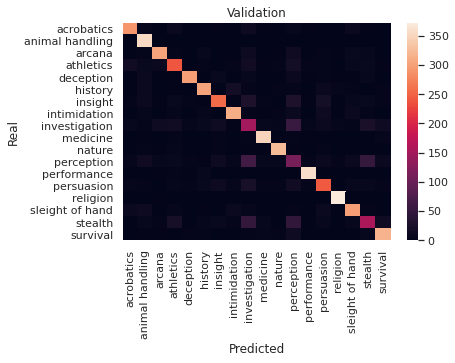

In [99]:
plot_confusion_matrix(skill_list, 'Validation', y_test, y_pred)

In [100]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

     acrobatics       0.86      0.85      0.85       345
animal handling       0.78      1.00      0.88       355
         arcana       0.86      0.82      0.84       373
      athletics       0.71      0.70      0.70       345
      deception       0.93      0.85      0.89       352
        history       0.85      0.82      0.84       370
        insight       0.80      0.66      0.72       388
   intimidation       0.86      0.84      0.85       372
  investigation       0.39      0.43      0.41       350
       medicine       0.90      0.94      0.92       374
         nature       0.91      0.93      0.92       351
     perception       0.32      0.33      0.33       335
    performance       0.93      0.96      0.95       374
     persuasion       0.72      0.69      0.71       355
       religion       0.95      0.99      0.97       374
sleight of hand       0.80      0.83      0.81       361
        stealth       0.55    